# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [84]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [85]:


cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Window2D_Data'
exp_date = '22Nov23'

spacing = 15           #how far did the windows spread around center --> 2*spacing
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [86]:
with open(f'{cwd_full}{base_file}/Espresso_Method/{exp_file}/hprParameter_{method}_sp_{spacing}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    rad_diff = dict['rad_diff']
    center1_array = dict['center1_array']
    center2_array = dict['center2_array']
    SNR_values = dict["SNR_values"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

### Standard Analysis

In [87]:
SR_folder = 'Comparison_DATA'
SR_date = '28Nov23'

In [88]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_SNRsuite_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_values"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_AIC_eval_iter = dict['AIC_eval_iter']
    SR_multi_start = dict['multi_start']
    handle.close()


for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

for iter in range(len(SNR_values)):
    assert(SR_SNR_values[iter] == SNR_values[iter])

# Functions

In [89]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_CENTER1 = np.stack(df["Center1"].values) #shape: (len(center_diff_range))
    ALL_CENTER2 = np.stack(df["Center2"].values) #shape: (len(center_diff_range))
    ALL_SNR = np.stack(df["SNR"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER1, ALL_CENTER2, ALL_SNR, ALL_TI, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [90]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(center1_array), len(center2_array), len(SNR_values), 3)) # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    var_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 3))
    bias_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 3))
    AIC_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 12))

    eqSNR_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values)))
    TI_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 12))

    pEst_AIC_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), var_reps, len(ParamTitle_6p)))
    pEst_cf_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), var_reps, len(ParamTitle_6p)))

    data_name = f"{cwd_full}{base_file}/Espresso_Method/{exp_file}/Window2D_{method}_sp_{spacing}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    Center1, Center2, SNR, TI_DATA, eqSNR, MSE, VAR, BIAS, AIC, pEst_AIC, pEst_cf = to_readable_2DWindow(data_name)

    for index in range(len(MSE)):

        temp_center1 = Center1[index]
        temp_center2 = Center2[index]
        temp_SNR = SNR[index]

        center1_index = np.where(temp_center1==center1_array)[0][0]
        center2_index = np.where(temp_center2==center2_array)[0][0]
        SNR_index = np.where(temp_SNR==SNR_values)[0][0]

        AIC_ordered[center1_index, center2_index, SNR_index,:] = AIC[index, :]/var_reps
        MSE_ordered[center1_index, center2_index, SNR_index,:] = MSE[index,:,p_oi]
        var_ordered[center1_index, center2_index, SNR_index,:] = VAR[index,:,p_oi]
        bias_ordered[center1_index, center2_index, SNR_index,:] = BIAS[index,:,p_oi]
        eqSNR_ordered[center1_index, center2_index, SNR_index,] = eqSNR[index]
        TI_ordered[center1_index, center2_index, SNR_index,:] = TI_DATA[index,:]
        pEst_AIC_ordered[center1_index, center2_index, SNR_index,:,:] = pEst_AIC[index,:,:]
        pEst_cf_ordered[center1_index, center2_index, SNR_index,:,:] = pEst_cf[index,:,:]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered, eqSNR_ordered, TI_ordered, pEst_AIC_ordered, pEst_cf_ordered

# Data Organization

In [91]:
MSE, var, bias, AIC, SNRs, TI_DATAs, pEst_AIC, pEst_cf = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/SNRsuite_{SR_date}.pkl"
SR_SNR, SR_MSE, SR_VAR, SR_BIAS, SR_AIC, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)


Retrieving data for /home/hamptong2/Stabilization/Espresso_Method/Window2D_Data/Window2D_AIC_sp_15_22Nov23.pkl


In [92]:
for i in range(9):
    print(np.sum(AIC[5,5,i,:]))

9.015
8.798
8.71
8.509999999999998
8.209
7.881999999999999
7.1
6.457000000000001
5.869


# Figure Functions

In [93]:
sp_map = plt.get_cmap('seismic_r')
sp_map.set_extremes(under = 'orange')
extend_opt = "min"      #max or none

def gen_patchwork_panel(fig, ax, ind_x, ind_y, SNR_value, imp_mat):
    ######## bottom left

    pos_max = np.max(imp_mat)

    plt.rc('font', size = 16)
    ax[ind_x, ind_y].set_title(f"SNR = {SNR_value}")
    imc1 = ax[ind_x, ind_y].imshow(imp_mat[:,:], cmap = sp_map, vmin = -1*pos_max, vmax = pos_max)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x, ind_y].set_xticks(np.arange(len(center2_array)))
    ax[ind_x, ind_y].set_yticks(np.arange(len(center1_array)))

    temp_x_labels = ["" for a in center2_array]
    x_array = [0,len(center2_array)//4,len(center2_array)//2, 3*len(center2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{center2_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in center1_array]
    y_array = [0,len(center1_array)//4,len(center1_array)//2, 3*len(center1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{center1_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_yticklabels(temp_y_labels)

    ax[ind_x, ind_y].set_ylabel(r'TI$_1^*$ Guess Offset')
    ax[ind_x, ind_y].set_xlabel(r'TI$_2^*$ Guess Offset')
    plt.rc('font', size = 12)
    cbar = fig.colorbar(imc1, ax=ax[ind_x, ind_y], fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
    cbar.formatter.set_powerlimits((0,0))

    return

In [94]:
bias_map = plt.get_cmap('turbo')
bias_map.set_extremes(over = 'black')
extend_opt = "max"      #max or none

def gen_patchwork_panel_wrongExtent(fig, ax, ind_x, ind_y, SNR_value, imp_mat):
    ######## bottom left

    neg_max = np.max(-1*imp_mat)

    plt.rc('font', size = 16)
    ax[ind_x, ind_y].set_title(f"SNR = {SNR_value}")
    imc1 = ax[ind_x, ind_y].imshow(imp_mat[:,:], cmap = bias_map, vmin = -1*neg_max, vmax = 0)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x, ind_y].set_xticks(np.arange(len(center2_array)))
    ax[ind_x, ind_y].set_yticks(np.arange(len(center1_array)))

    temp_x_labels = ["" for a in center2_array]
    x_array = [0,len(center2_array)//4,len(center2_array)//2, 3*len(center2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{center2_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in center1_array]
    y_array = [0,len(center1_array)//4,len(center1_array)//2, 3*len(center1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{center1_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_yticklabels(temp_y_labels)

    ax[ind_x, ind_y].set_ylabel(r'TI$_1^*$ Guess Offset')
    ax[ind_x, ind_y].set_xlabel(r'TI$_2^*$ Guess Offset')
    plt.rc('font', size = 12)
    cbar = fig.colorbar(imc1, ax=ax[ind_x, ind_y], fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
    cbar.formatter.set_powerlimits((0,0))

    return

In [95]:
AIC_map = plt.get_cmap('turbo')

def gen_patchwork_panel_AIC(fig, ax, ind_x, ind_y, SNR_value, imp_mat):
    ######## bottom left

    plt.rc('font', size = 16)
    ax[ind_x, ind_y].set_title(f"SNR = {SNR_value}")
    imc1 = ax[ind_x, ind_y].imshow(imp_mat[:,:], cmap = AIC_map, vmin = 6, vmax = AIC.shape[-1]-2)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x, ind_y].set_xticks(np.arange(len(center2_array)))
    ax[ind_x, ind_y].set_yticks(np.arange(len(center1_array)))

    temp_x_labels = ["" for a in center2_array]
    x_array = [0,len(center2_array)//4,len(center2_array)//2, 3*len(center2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{center2_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in center1_array]
    y_array = [0,len(center1_array)//4,len(center1_array)//2, 3*len(center1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{center1_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_yticklabels(temp_y_labels)

    ax[ind_x, ind_y].set_ylabel(r'TI$_1^*$ Guess Offset')
    ax[ind_x, ind_y].set_xlabel(r'TI$_2^*$ Guess Offset')
    plt.rc('font', size = 12)
    cbar = fig.colorbar(imc1, ax=ax[ind_x, ind_y], fraction=0.046, pad=0.2, location = 'bottom')#, format = '%.2e')
    # cbar.formatter.set_powerlimits((0,0))

    return

# Heat Maps

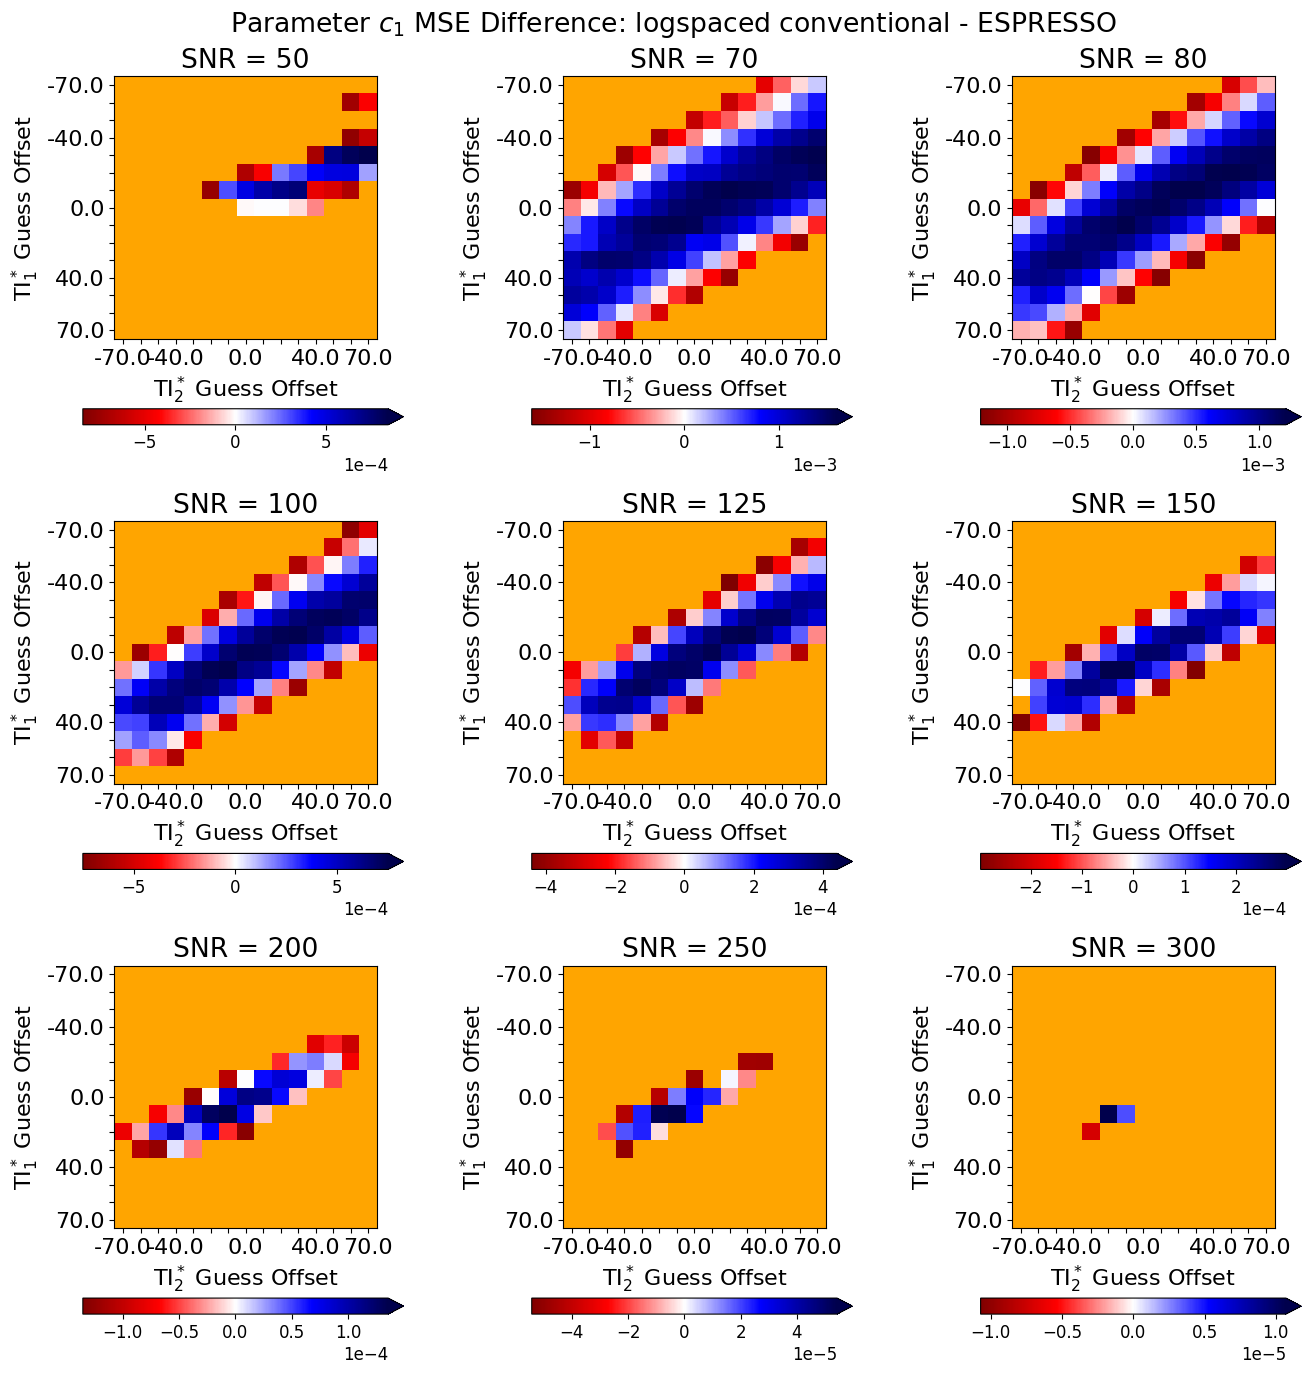

In [96]:
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]

plt.rc('font', size = 16)
fig, ax_MSE = plt.subplots(3,3, figsize = (14, 14), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Difference: logspaced conventional - ESPRESSO")

for ii in range(len(x_patches)):
    temp_MSE_ESPRESSO = MSE[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]

    temp_SR_MSE = SR_MSE[SNR_index,2,param_oi]

    temp_MSE_imp = temp_SR_MSE-temp_MSE_ESPRESSO

    gen_patchwork_panel(fig, ax_MSE, x_patches[ii], y_patches[ii], SNR_values[ii], temp_MSE_imp)

# ax_MSE[1,2].remove()


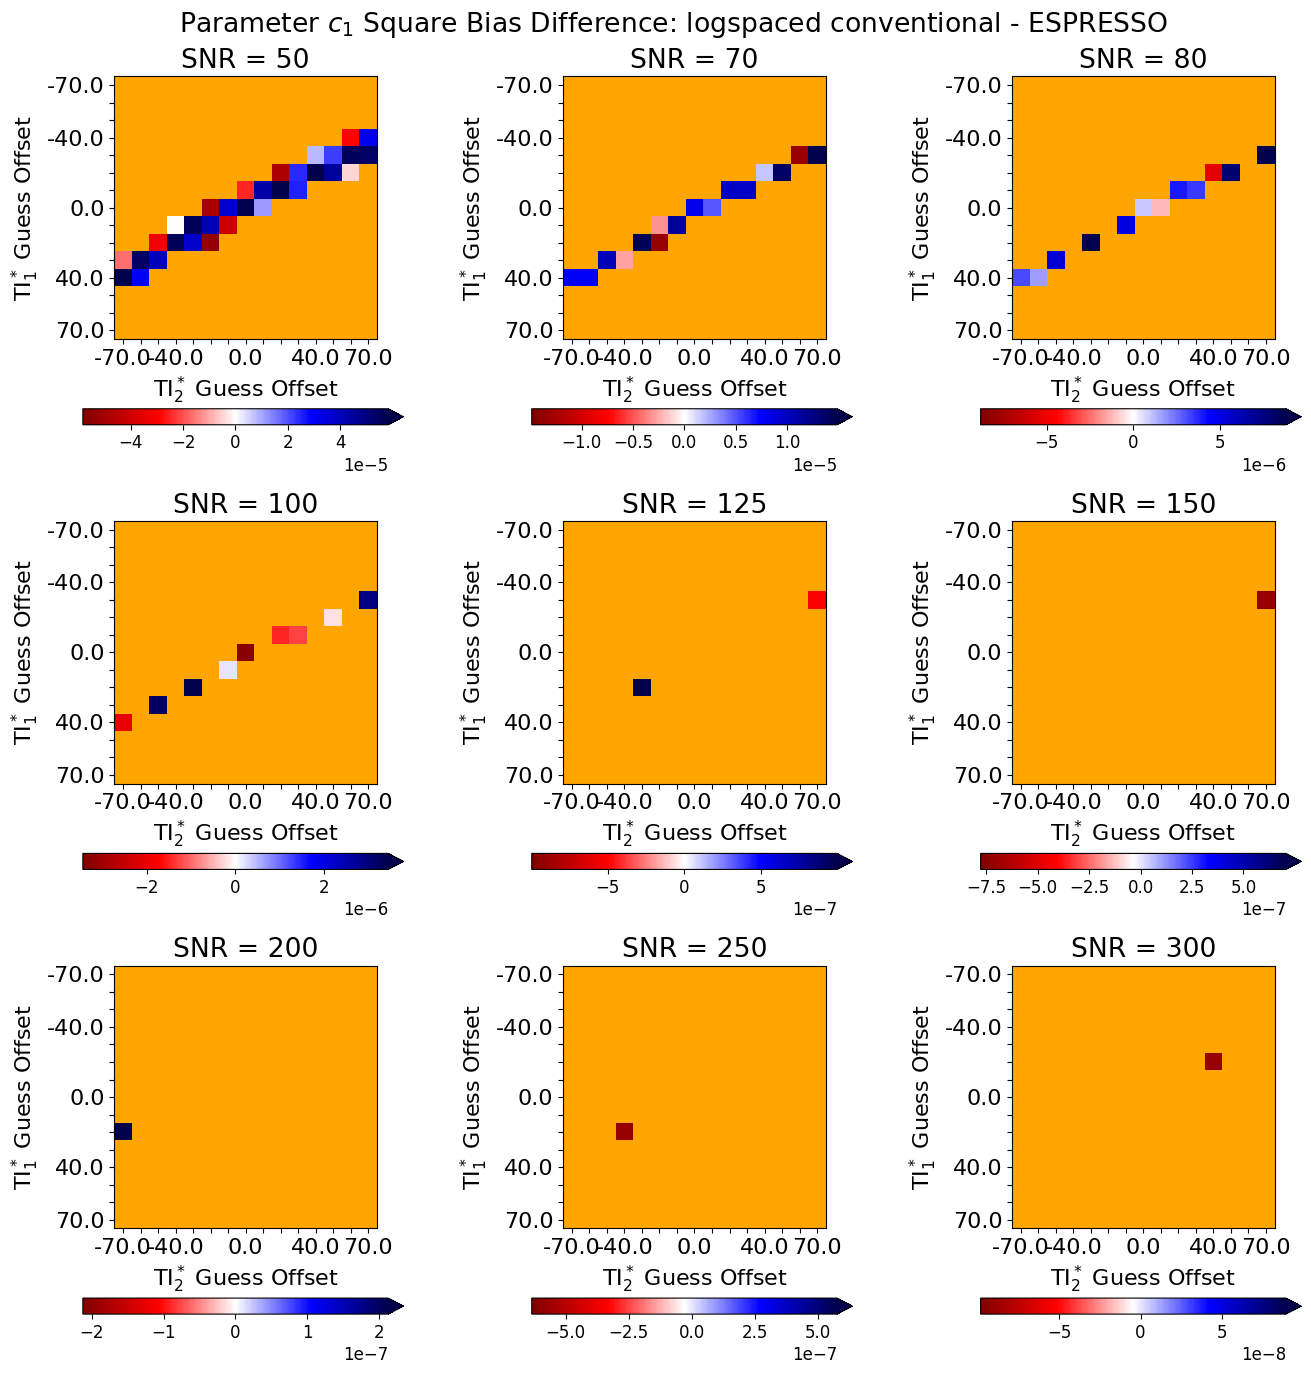

In [97]:
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]


plt.rc('font', size = 16)
fig, ax_sqbias = plt.subplots(3,3, figsize = (14, 14), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} Square Bias Difference: logspaced conventional - ESPRESSO")


for ii in range(len(x_patches)):

    temp_bias_ESPRESSO = bias[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_bias = SR_BIAS[SNR_index,2,param_oi]
    temp_sqbias_imp = temp_SR_bias**2-temp_bias_ESPRESSO**2

    gen_patchwork_panel(fig, ax_sqbias, x_patches[ii], y_patches[ii], SNR_values[ii], temp_sqbias_imp)

# ax_sqbias[1,2].remove()


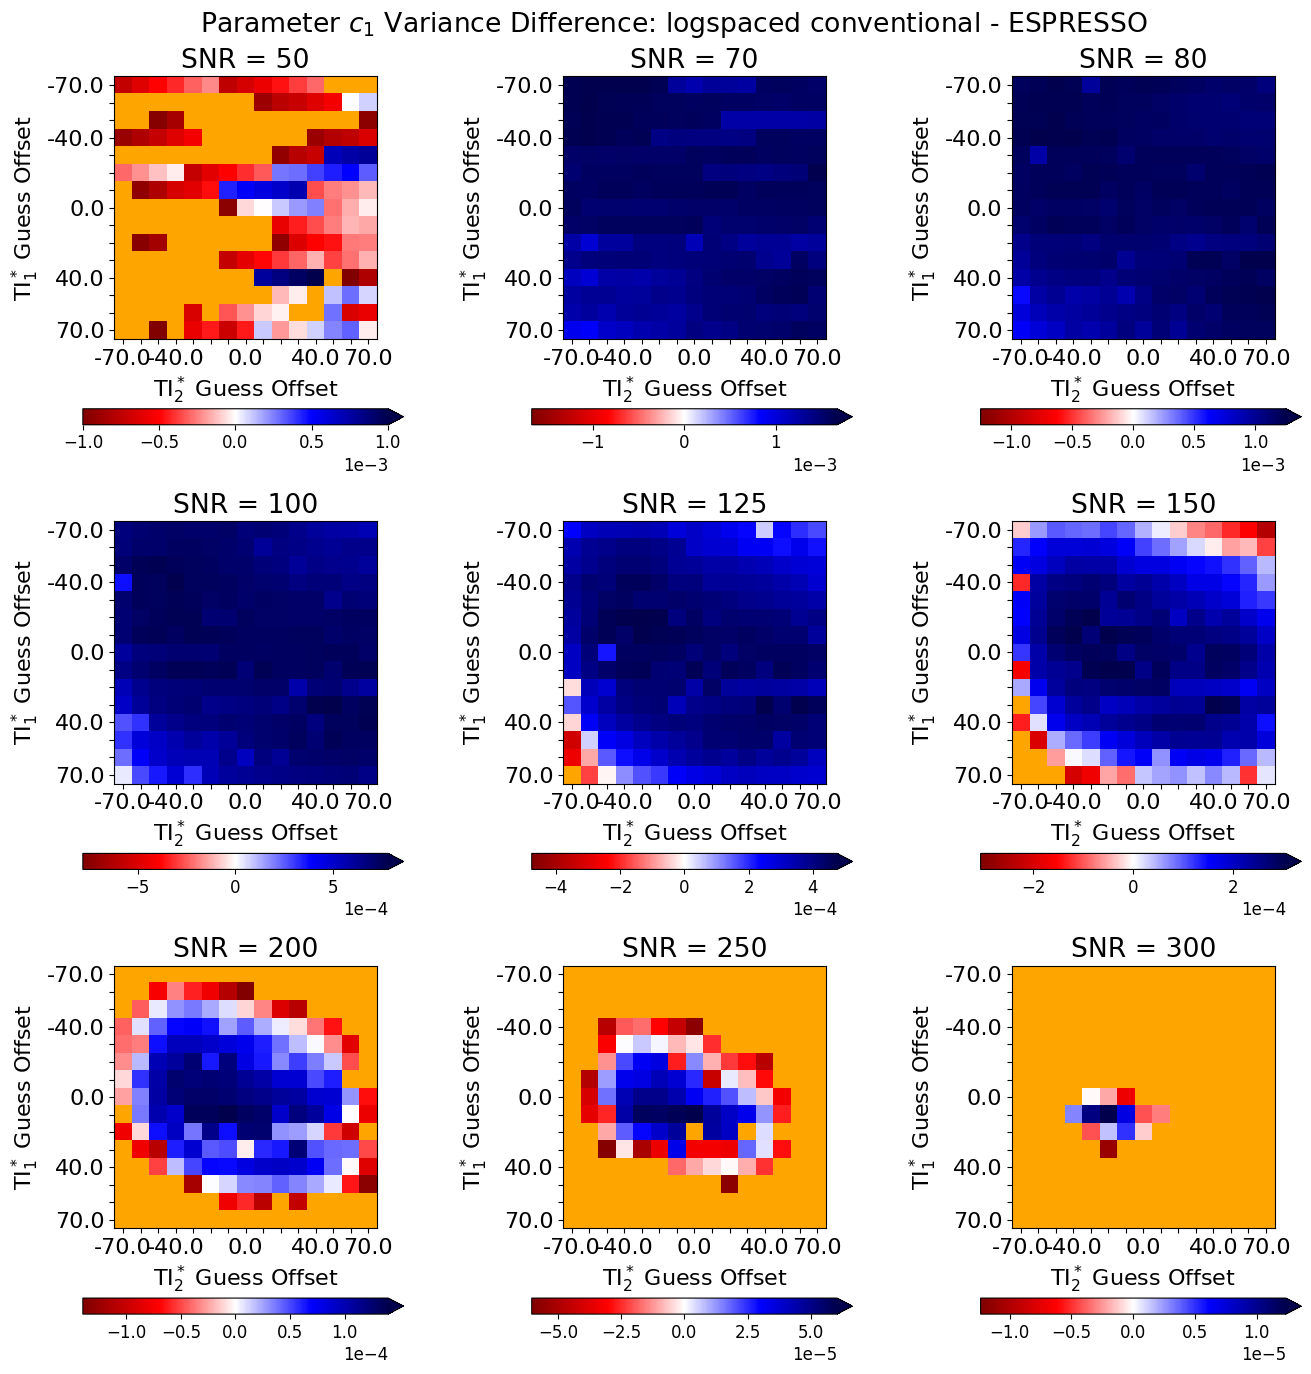

In [98]:
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]


plt.rc('font', size = 16)
fig, ax_var = plt.subplots(3,3, figsize = (14, 14), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} Variance Difference: logspaced conventional - ESPRESSO")

for ii in range(len(x_patches)):
    temp_var_ESPRESSO = var[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_var = SR_VAR[SNR_index,2,param_oi]

    temp_var_imp = temp_SR_var-temp_var_ESPRESSO

    gen_patchwork_panel(fig, ax_var, x_patches[ii], y_patches[ii], SNR_values[ii], temp_var_imp)

# ax_var[1,2].remove()


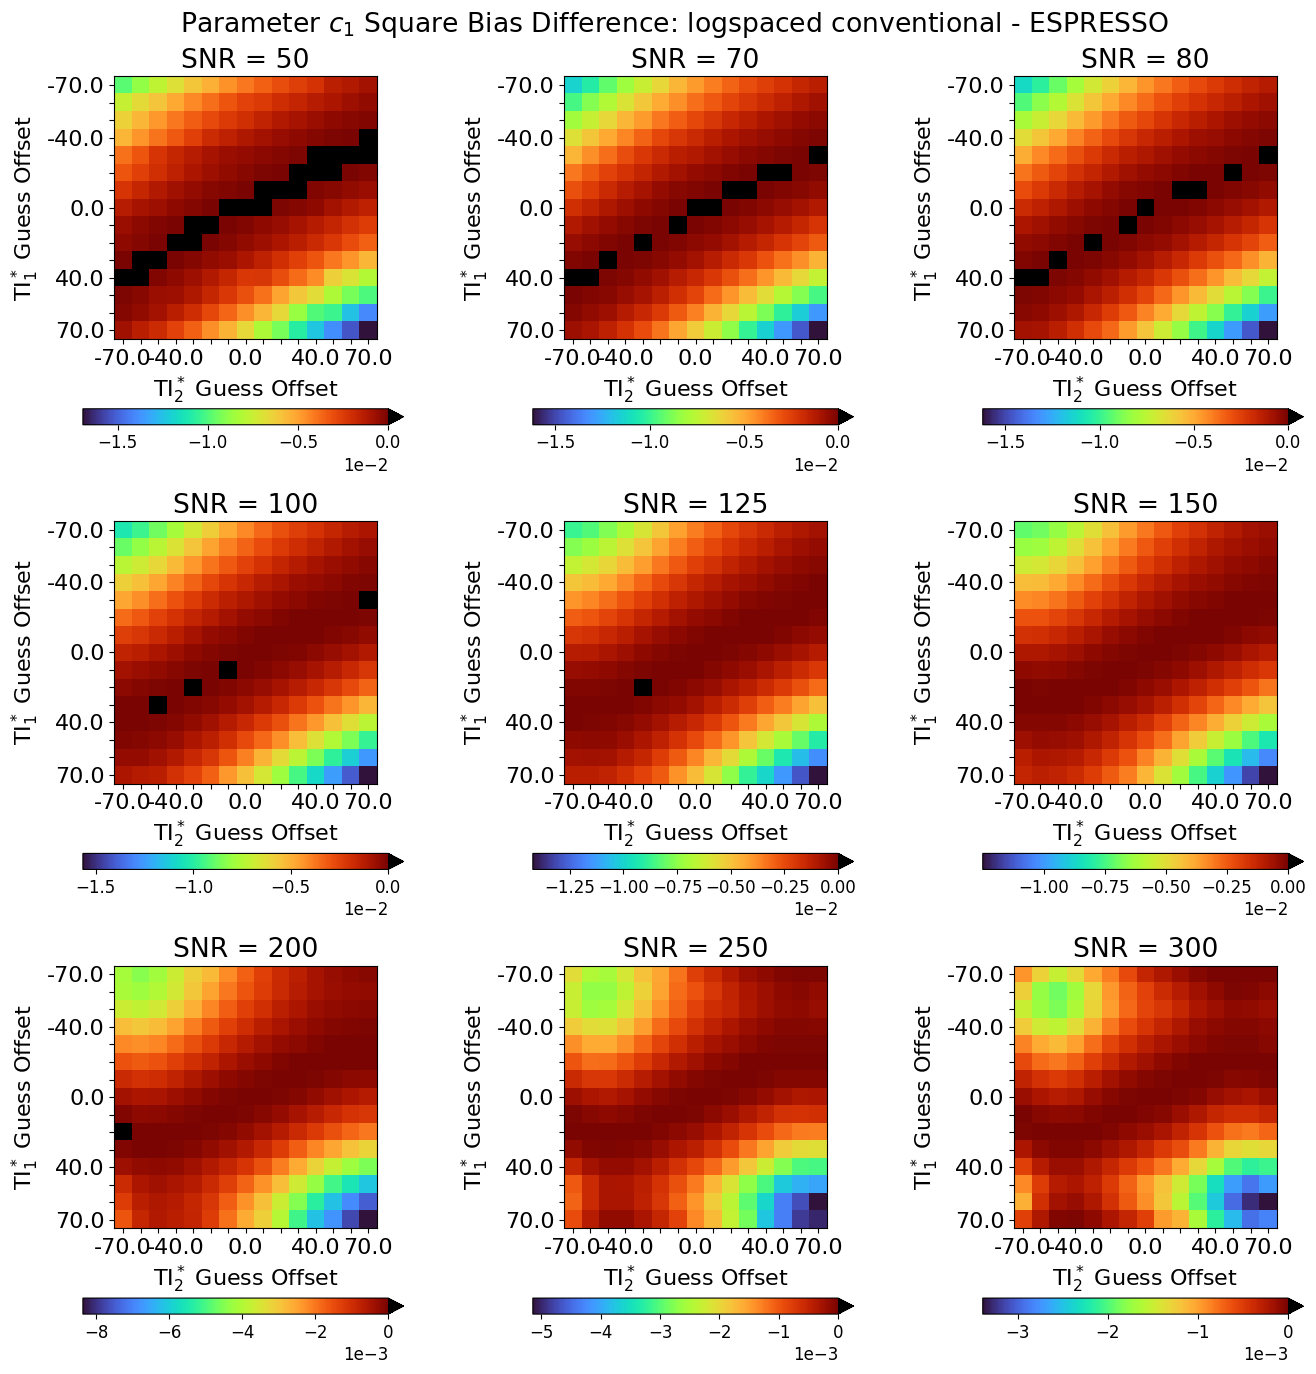

In [99]:
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]


plt.rc('font', size = 16)
fig, ax_sqbias = plt.subplots(3,3, figsize = (14, 14), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} Square Bias Difference: logspaced conventional - ESPRESSO")


for ii in range(len(x_patches)):

    temp_bias_ESPRESSO = bias[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_bias = SR_BIAS[SNR_index,2,param_oi]
    temp_sqbias_imp = temp_SR_bias**2-temp_bias_ESPRESSO**2

    gen_patchwork_panel_wrongExtent(fig, ax_sqbias, x_patches[ii], y_patches[ii], SNR_values[ii], temp_sqbias_imp)

# ax_sqbias[1,2].remove()

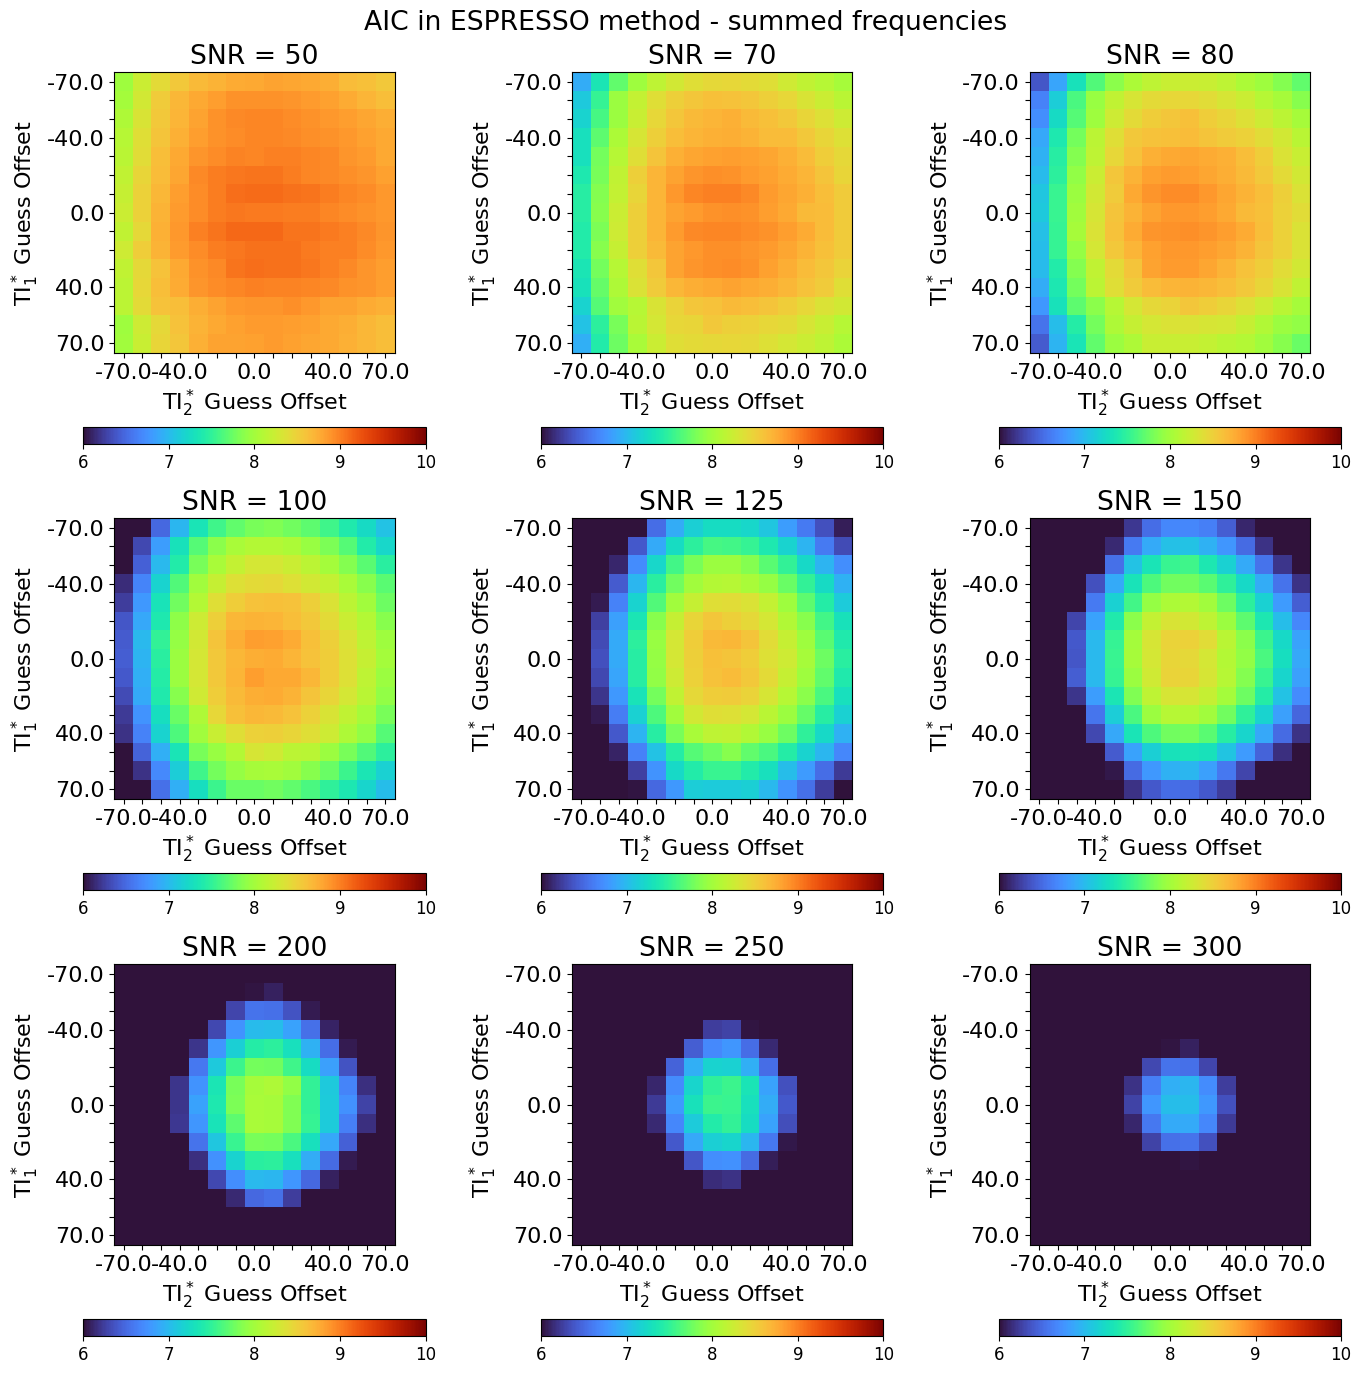

In [100]:
x_patches = [0,0,0,1,1,1,2,2,2]
y_patches = [0,1,2,0,1,2,0,1,2]


plt.rc('font', size = 16)
fig, ax_sqbias = plt.subplots(3,3, figsize = (14, 14), tight_layout=True)
fig.suptitle(f"AIC in ESPRESSO method - summed frequencies")


for ii in range(len(x_patches)):

    temp_AIC_sum = np.sum(AIC[:,:,ii,:], axis = -1)

    gen_patchwork_panel_AIC(fig, ax_sqbias, x_patches[ii], y_patches[ii], SNR_values[ii], temp_AIC_sum)

# ax_sqbias[1,2].remove()

# Example Pixel Histograms

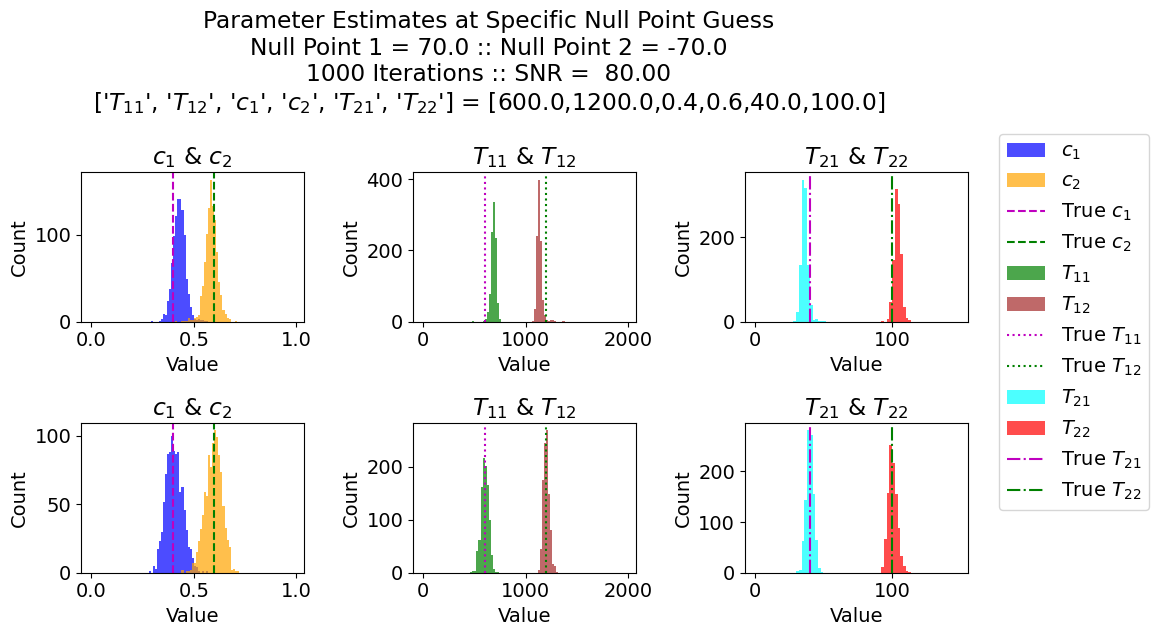

In [101]:
center1_ioi = -1
center2_ioi = 0
SNR_oi = 80
SNR_index = np.where(SNR_oi==SNR_values)[0][0]


plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {center1_array[center1_ioi]} :: Null Point 2 = {center2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_oi : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")#\nFreq = {AIC[center1_ioi, center2_ioi, SNR_index,:]/var_reps}")

# labels = get_param_list(S_biX_6p)
# lb, ub = get_func_bounds(S_biX_6p)

# MSEMat, varMat, sqBMat = calc_MSE(param_est_AIC, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
# ax[0,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[0,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
# ax[0,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[0,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
# ax[0,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[0,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


# MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
# ax[1,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[1,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
# ax[1,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[1,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
# ax[1,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[1,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

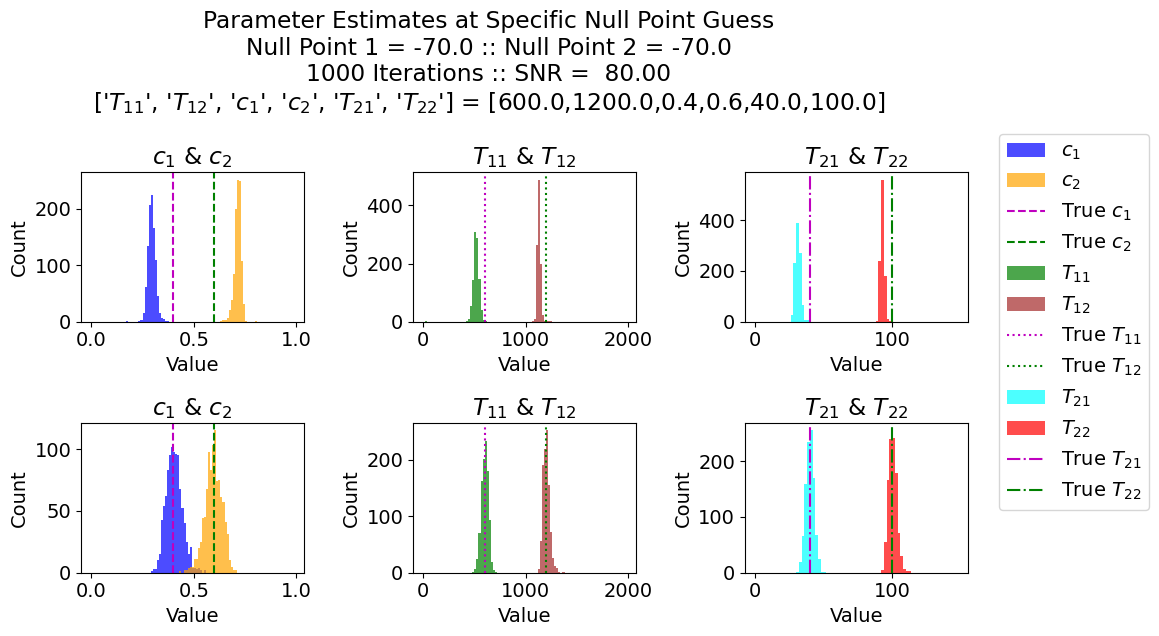

In [102]:
center1_ioi = 0
center2_ioi = 0
SNR_oi = 80
SNR_index = np.where(SNR_oi==SNR_values)[0][0]


plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {center1_array[center1_ioi]} :: Null Point 2 = {center2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_oi : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")#\nFreq = {AIC[center1_ioi, center2_ioi, SNR_index,:]/var_reps}")

# labels = get_param_list(S_biX_6p)
# lb, ub = get_func_bounds(S_biX_6p)

# MSEMat, varMat, sqBMat = calc_MSE(param_est_AIC, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
# ax[0,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[0,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
# ax[0,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[0,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi, SNR_index,:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
# ax[0,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[0,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


# MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
# ax[1,0].set_xlim([lb[-3],ub[-3]])
# ymin, ymax = ax[1,0].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
# ax[1,1].set_xlim([lb[0],ub[0]])
# ymin, ymax = ax[1,1].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi, SNR_index,:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
# ax[1,2].set_xlim([lb[-1],ub[-1]])
# ymin, ymax = ax[1,2].get_ylim()
# yup = ymin+(ymax-ymin)*2//3
# ydn = ymin+(ymax-ymin)*1//3
# ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))